# Dashboard

A summary of model results, including:
- Total energy
- Distribution Output / input energy
- TODO Energy distribution 
  - metrics: Get histogram/kernel distribution of energy vs. p(energy) for a given cube, slice, pixel, or even type and incoming energy
- Energy spread
- Depth of max energy slice
- % of pixels that are zero

Where applicable, these metrics will be applied to: 
- Entire dataset
- A batch
- A cube
- A slice
- A pixel 

## TODO
- Average energy spread across samples before plotting
- Produce a single image of output
- Clean it up, put it into eval.py or dashboard.py
- Incorporate Alex's energy distribution plot
- Incorporate Alex's output/input energy ratio plots

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import keras
import seaborn as sns

import sys
sys.path.append('../scripts')
import data_loader
import viz_tools
import rnn_flat
import eval
% matplotlib inline

Using TensorFlow backend.
/Users/charguth/anaconda3/envs/py27/lib/python2.7/site-packages/IPython/html.py:14: ShimWarning: The `IPython.html` package has been deprecated since IPython 4.0. You should import from `notebook` instead. `IPython.html.widgets` has moved to `ipywidgets`.
  "`IPython.html.widgets` has moved to `ipywidgets`.", ShimWarning)
/Users/charguth/anaconda3/envs/py27/lib/python2.7/site-packages/matplotlib/__init__.py:1401: UserWarning:  This call to matplotlib.use() has no effect
because the backend has already been chosen;
matplotlib.use() must be called *before* pylab, matplotlib.pyplot,
or matplotlib.backends is imported for the first time.

  warnings.warn(_use_error_msg)


In [2]:
def get_pct_zero(ecal):
    '''
    args:
        ecal: (numpy array) can be a cube, slice, or pixel
    returns:
        sum of the pixel intensities
    '''
    flat_ecal = ecal.flatten()
    zeros = flat_ecal[np.where(flat_ecal == 0.0)]
    return float(len(zeros))/len(flat_ecal)

In [3]:
def get_max_layer(ecals):
    '''
    Takes a batch of cubes, and for each cube:
        Gets the depth of the layer in the cube 
        with the highest total energy
    args:
        ecals (np.array): either 3D batch of 2D shades, 
        or 4D batch of 3D cubes) 
    returns:
        vector of depths
    '''
    #TODO fix all this shit to do what the docstring says it does
    assert len(ecals.shape)==4
    ecals = data_loader.unroll_ecals(ecals)
    sums = ecals.sum(axis=1)
    return sums.argmax(axis=1)

In [4]:
def plot_depth_histogram(real,gen):
    #TODO split into different particle types
    real_depths = get_max_layer(real)
    gen_depths = get_max_layer(gen)
    
    # Subfunction to create a histogram for one of the two kinds of particles.
    def create_particle_histogram(real_depths, gen_depths, ax):

        # When plotting the two histograms together, throw out huge outliers to ensure the graph is
        # interpretable. 4 standard deviations should be plenty.
        gen_depth_deviations = abs(gen_depths - np.mean(gen_depths)) / np.std(gen_depths)
        trunc_gen_depths = gen_depths[gen_depth_deviations < 4]
        # Set the boundaries of the histogram based on the max and min of the data
        hist_range = (min(min(real_depths), min(trunc_gen_depths)),
                      max(max(real_depths), max(trunc_gen_depths)))
        real_hist_label = 'Real: $\mu={0:.2f}$, $\sigma={1:.2f}$'.format(real_depths.mean(),
                                                                         real_depths.std())
        ax.hist(real_depths, bins='auto', range=hist_range, color='red', label=real_hist_label,
                histtype='step')
        # Use the untruncated generated data for the mean and standard deviation stats, since the
        # truncated data just serves to make the picture look readable.
        gen_hist_label = 'Gen: $\mu={0:.2f}$, $\sigma={1:.2f}$'.format(gen_depths.mean(),
                                                                       gen_depths.std())
        ax.hist(trunc_gen_depths, bins='auto', range=hist_range, color='green',
                label=gen_hist_label, histtype='step')
        # TODO The 'best' legend location doesn't work that well...
        ax.legend(loc='best', fancybox=True, framealpha=0.7)
        ax.set_xlabel('Depth of maximum-energy layer')
        ax.set_ylabel('Count')
        ax.set_title('Distribution of Max-Layer Depths')
    fig, ax = plt.subplots(1)
    create_particle_histogram(real_depths,gen_depths, ax)
    #create_particle_histogram(p1_energy_data, ax1)

    fig.tight_layout()    

    #st = fig.suptitle('Particle Output-to-Input Energy Ratio Histogram',
    #                  fontsize="x-large")
    # shift subplots down:
    #st.set_y(0.95)
    #fig.subplots_adjust(top=0.85)

    #step_str = '-{}'.format(step) if step is not None else ''
    #filename = 'energy-hist{}.png'.format(step_str)
    #full_path = os.path.join(output_dir, filename)
    #plt.savefig(full_path)
    plt.show()

In [5]:
def evaluate_gen(real,gen, sample_id):
    '''
    args:
        real: (array) real cube, of shape (batch_size,width,height,depth)
        gen: (array) batch of generated cubes, of shape (batch_size,width,height,depth)
        sample_id: index of a sample to compare
    '''
    
    print "Total Energy Per Cube"
    real_energy_per_cube = np.sum(real)/real.shape[0]
    print "Real: {:.1f}".format(real_energy_per_cube)
    gen_energy_per_cube = np.sum(gen)/gen.shape[0]
    print "Generated: {:.1f}".format(gen_energy_per_cube)
    
    print "\nPercent Zero"
    print "Real: {:.1f}%".format(100*get_pct_zero(real))
    print "Generated: {:.1f}%".format(100*get_pct_zero(gen))
    
    plot_depth_histogram(real,gen)
    eval.plot_dispersion(gen[sample_id],real[sample_id])

In [6]:
dl = data_loader.DataLoader([100], test=True)
trunc_iter = dl.batch_iter(0,batch_size=100, num_epochs=2)
real,_ = trunc_iter.next()
#TODO NOTE I'm truncating to the first 24 layers to equal gen
real = real[:,:,:,:24]

In [7]:
saved_model = '../rnntest_model'
model = keras.models.load_model(saved_model)

/Users/charguth/anaconda3/envs/py27/lib/python2.7/site-packages/keras/engine/topology.py:1206: UserWarning: The `Merge` layer is deprecated and will be removed after 08/2017. Use instead layers from `keras.layers.merge`, e.g. `add`, `concatenate`, etc.
  return cls(**config)


In [8]:
rnn_inputs = rnn_flat.rnn_generator([90,10],10,n_epochs=1,test=True,partition=1)
rnn_input = rnn_inputs.next()
gen = model.predict(rnn_input[0])
gen = gen.swapaxes(1,2).reshape(10,20,20,24)

Total Energy Per Cube
Real: 4112.1
Generated: 3829.9

Percent Zero
Real: 87.4%
Generated: 86.8%

Dist. of Depths of Highest-Energy Layers (per cube)


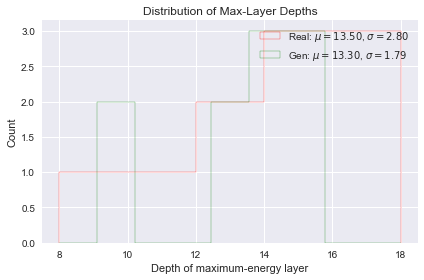

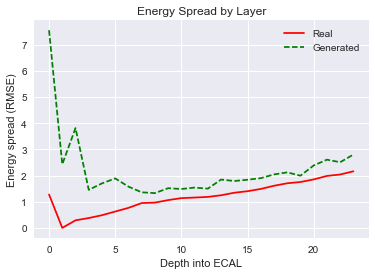

In [9]:
evaluate_gen(real,gen,5)

# TODO
- import batch of real and generated data using Israel's code.  More generally, load a model and data, then use the model to produce generated data.  Then we have batches of real and gen tensors
- write a function to run the vis modules already built to create the suite of visualizations for the dashboard